# Notebook 1 - Preprocessing of metabolomic data acquired from plasma samples from COVID patients. 

#### This notebook is a part of a project with the Center for Systems Biology at the University of Iceland. The goal is to take raw metabolomic data (in negative acidic mode, positive acidic mode, and negative basic mode) that was run through XCMS, run it through QC-RLSC signal correction to account for signal drift in the LC-MS, remove too variable variables (according to QC samples), remove outlier samples, perform batch effect correction, join features that are very similar in m/z and highly correlated, scale the data and finally join the three metabolomic modes into a single dataframe to use for weighted network correlation analysis in R

## Import modules:

In [1]:
import pandas as pd
import numpy as np
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from combat.pycombat import pycombat
import itertools
import kneed
import sklearn
import random
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from kneed import KneeLocator
from scipy.stats import spearmanr, pearsonr

## Define functions:

In [17]:
def crop_filter_features(dat,min_rt,min_mz):
    '''
    This is the first step in the pre-processing - the removal of features which we are not interested in (fragments or junk 
    eluting from column in the beginning)
    '''
    dat2 = dat.copy()
    dat2 = dat2[dat2['mz'] > min_mz].reset_index()
    dat2 = dat2[dat2['rt'] > min_rt].reset_index()
    return dat2

def tricubic(x):
    y = np.zeros_like(x)
    idx = (x >= -1) & (x <= 1)
    y[idx] = np.power(1.0 - np.power(np.abs(x[idx]), 3), 3)
    return y


class Loess(object):

    @staticmethod
    def normalize_array(array):
        min_val = np.nanmin(array)
        max_val = np.nanmax(array)
        return (array - min_val) / (max_val - min_val), min_val, max_val

    def __init__(self, xx, yy, degree=1):
        self.n_xx, self.min_xx, self.max_xx = self.normalize_array(xx)
        self.n_yy, self.min_yy, self.max_yy = self.normalize_array(yy)
        self.degree = degree

    @staticmethod
    def get_min_range(distances, window):
        min_idx = np.argmin(distances)
        n = len(distances)
        if min_idx == 0:
            return np.arange(0, window)
        if min_idx == n-1:
            return np.arange(n - window, n)

        min_range = [min_idx]
        while len(min_range) < window:
            i0 = min_range[0]
            i1 = min_range[-1]
            if i0 == 0:
                min_range.append(i1 + 1)
            elif i1 == n-1:
                min_range.insert(0, i0 - 1)
            elif distances[i0-1] < distances[i1+1]:
                min_range.insert(0, i0 - 1)
            else:
                min_range.append(i1 + 1)
        return np.array(min_range)

    @staticmethod
    def get_weights(distances, min_range):
        max_distance = np.max(distances[min_range])
        weights = tricubic(distances[min_range] / max_distance)
        return weights

    def normalize_x(self, value):
        return (value - self.min_xx) / (self.max_xx - self.min_xx)

    def denormalize_y(self, value):
        return value * (self.max_yy - self.min_yy) + self.min_yy

    def estimate(self, x, window, use_matrix=False, degree=1):
        n_x = self.normalize_x(x)
        distances = np.abs(self.n_xx - n_x)
        min_range = self.get_min_range(distances, window)
        weights = self.get_weights(distances, min_range)

        if use_matrix or degree > 1:
            wm = np.multiply(np.eye(window), weights)
            xm = np.ones((window, degree + 1))

            xp = np.array([[math.pow(n_x, p)] for p in range(degree + 1)])
            for i in range(1, degree + 1):
                xm[:, i] = np.power(self.n_xx[min_range], i)

            ym = self.n_yy[min_range]
            xmt_wm = np.transpose(xm) @ wm
            beta = np.linalg.pinv(xmt_wm @ xm) @ xmt_wm @ ym
            y = (beta @ xp)[0]
        else:
            xx = self.n_xx[min_range]
            yy = self.n_yy[min_range]
            sum_weight = np.sum(weights)
            sum_weight_x = np.dot(xx, weights)
            sum_weight_y = np.dot(yy, weights)
            sum_weight_x2 = np.dot(np.multiply(xx, xx), weights)
            sum_weight_xy = np.dot(np.multiply(xx, yy), weights)

            mean_x = sum_weight_x / sum_weight
            mean_y = sum_weight_y / sum_weight

            b = (sum_weight_xy - mean_x * mean_y * sum_weight) / \
                (sum_weight_x2 - mean_x * mean_x * sum_weight)
            a = mean_y - b * mean_x
            y = a + b * n_x
        return self.denormalize_y(y)

    
def QC_RLSC(dat,degree,window_frac):
    '''
    A function to perform robust-loess signal correction. Does it using a specified degree linear regression using a window size of window_frac
    times the total number of qc samples. The "dat" is a pandas DataFrame with the first 4 columns as "MS_id", "Run order","Batch","QC". 
    The fifth column should be the first sample and the last column the last sample. This should only take one method at a time 
    (Negative, positive, basic etc. )
    '''
    batches = np.unique(dat['Batch'])
    for batch in batches:
        dat2 = dat[dat['Batch'] == batch]
        dat2_qc = dat2[dat2['QC'] == 1]
        dat2_meas = dat2[dat2['QC'] == 0]
        dat2_out = dat2.copy()
        xx = np.array(dat2_qc['Run_order'],dtype = 'float')
        for columnn in range(4,dat2.shape[1]):
            yy = np.array(dat2_qc.iloc[:,columnn],dtype = 'float')
            #print(xx)
            #print(yy)
            #yy = np.array(dat2_meas.iloc[:,columnn],dtype = 'float')
            loess = Loess(xx, yy, degree = degree)
            # Normalise the values for each different run order:
            normalised_values = np.zeros(dat2.shape[0])
            for idxx,value in enumerate(dat2.iloc[:,columnn]):
                tmp_run_order = dat2.iloc[idxx,1]
                norm_factor = loess.estimate(tmp_run_order, window=round(window_frac*len(xx)))
                #print(norm_factor)
                #norm_factor = random.random()
                normalised_values[idxx] = value/norm_factor
            dat2_out.iloc[:,columnn] = normalised_values
        if batch == 1:
            df_out = dat2_out
        else:
            df_out = pd.concat([df_out,dat2_out],axis = 0)
        
    return df_out

def coef_var(array):
    value = (np.std(array)/np.mean(array))*100
    return value

def remove_unwanted_features(data_normalised,data_original,coef_var_threshold,d_ratio_threshold):
    '''
    Again, needs to have that specific structure (first four columns metadata). 
    This function removes features that have too high variation in the QC samples (above coef_var_threshold)
    and features that have too high variation in the qc samples COMPARE to the biological samples (D-ratio above d_ratio_threshold)
    
    
    '''
    data_normalised2 = data_normalised.copy()
    data_original2 = data_original.copy()
    
    dat_orig = data_original2[data_original2['QC'] == 1]
    dat_norm = data_normalised2[data_original2['QC'] == 1]

    norm_cv = []
    orig_cv = []
    for columnn in range (4,dat_norm.shape[1]):
        norm_cv.append(coef_var(dat_norm.iloc[:,columnn]))
        orig_cv.append(coef_var(dat_orig.iloc[:,columnn]))


    df = pd.DataFrame([orig_cv+norm_cv,['Original']*len(orig_cv)+['Normalised']*len(norm_cv)]).T
    df.columns = ['Value','Type']
    mean_normal = np.nanmedian(norm_cv)
    mean_orig = np.nanmedian(orig_cv)
    figg = sns.kdeplot(data=df, x="Value", hue="Type",alpha = .5,fill = True)
    plt.axvline(x=mean_normal,color='orange',ls = '--')
    plt.axvline(x=mean_orig,color='blue',ls = '--')
    plt.xlim([0, 50])
    plt.show()
    
    # Return the ids of the features with more than "coef_var_threshold" coef of variation:
    id_remove = [idxx + 4 for (idxx,x) in enumerate(norm_cv) if x > coef_var_threshold]
    data_normalised_out = data_normalised2.drop(data_normalised2.columns[id_remove],axis=1)
    data_original_out = data_original2.drop(data_original2.columns[id_remove],axis=1)
    
    # Calculate D-ratio of remaining features. This applies only too normalised features:
    #dat_orig2_qc = data_original_out[data_original_out['QC'] == 1]
    dat_norm2_qc = data_normalised_out[data_normalised_out['QC'] == 1]
    
    #dat_orig2_nonqc = data_original_out[data_original_out['QC'] == 0]
    dat_norm2_nonqc = data_normalised_out[data_normalised_out['QC'] == 0]
    
    d_ratio_normalised = []
    for columnn in range (4,dat_norm2_qc.shape[1]):
        tmp_val = (np.std(dat_norm2_qc.iloc[:,columnn])/np.std(dat_norm2_nonqc.iloc[:,columnn]))*100
        d_ratio_normalised.append(tmp_val)
    
    # Return the ids of the features with more than "d_ratio_threshold" D-ratio:
    id_remove2 = [idxx + 4 for (idxx,x) in enumerate(d_ratio_normalised) if x > d_ratio_threshold]
    data_normalised_out2 = data_normalised_out.drop(data_normalised_out.columns[id_remove2],axis=1)
    data_original_out2 = data_original_out.drop(data_original_out.columns[id_remove2],axis=1)
    
    return data_normalised_out2, data_original_out2

def outlier_detection_and_removal(data, s):
    '''
    The data structure needs to be the same as for the QC-RLSC (first four columns are metadata). This uses DBSCAN to detect 
    outliers. 
    s is the sensitivity to knee detection in the distance graph. 
    '''
    data2 = data.copy()
    dat_norm_pca = data2.iloc[:,4:]
    dat_norm_pca.index = data2['MS_id']
    scaler2 = StandardScaler()
    norm_scaled = scaler2.fit_transform(dat_norm_pca)
    
    # Perform PCA:
    pca2 = PCA(n_components=2)
    norm_pca = pca2.fit_transform(norm_scaled)
    
    # Find optimal eps value for DBSCAN:
    neigh = NearestNeighbors(n_neighbors=10)
    nbrs = neigh.fit(norm_scaled)
    distances, indices = nbrs.kneighbors(norm_scaled)

    # Prepare distances for plotting:
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]

    # Find "knee" in distances:
    kn = KneeLocator(range(0,len(distances)), distances, curve='convex', direction='increasing', S = s)
    
    if kn.knee is not None:
    # Value to compare to as knee:
        knee = kn.knee_y*1.1

        # Plot the eps values and the identified knee:
        plt.plot(distances)
        plt.axvline(x = kn.knee, color = 'r', linestyle = 'dashed') 
        plt.axhline(y = kn.knee_y, color = 'r', linestyle = 'dashed') 
        plt.show()

        # Find the outliers given the 
        model = DBSCAN(eps=knee, min_samples=10).fit(norm_scaled)
        colors = ['royalblue', 'navy', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'red']
        vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

        # Use the PCA to plot scatterplot:
        plt.scatter(norm_pca.T[0],norm_pca.T[1], c=vectorizer(model.labels_))
        plt.show()

        samples_to_remove = np.where(model.labels_ == -1)[0].tolist()
        out_dat = data2.drop(samples_to_remove)
        out_dat.reset_index()
    else:
        print('No knee detected. No outliers were removed')
        out_dat = data2
    return out_dat


def PCA_visualisation(data):
    '''
    Needs to have that same structure as rest of functions. 
    '''
    dat_norm_pca = data.iloc[:,4:]
    scaler1 = StandardScaler()
    norm_scaled = scaler1.fit_transform(dat_norm_pca)
    pca1 = PCA(n_components=4)
    norm_pca = pca1.fit_transform(norm_scaled)

    # Create df with labelelled QC:
    df_pca = pd.DataFrame([data['Batch'].tolist(),data['QC'].tolist(),norm_pca.T[0],norm_pca.T[1]]).T
    df_pca.columns = ['Batch','QC','PC1','PC2']

    figg = sns.scatterplot(x = df_pca['PC1'],y = df_pca['PC2'],hue = df_pca['QC'],style = df_pca['Batch'])
    plt.show()
    return

def match_ms_samples_to_patients(normalised_data,ms_info):
    list_of_patients = normalised_data['MS_id'].tolist()
    dict_patients = dict(zip(ms_info['MS_RAW'],ms_info['SAMPLE_ID']))
    ordered_patient_ids = [dict_patients[x] for x in list_of_patients]
    assert len(ordered_patient_ids) == len(list_of_patients)
    out_data = normalised_data.copy()
    out_data['MS_id'] = ordered_patient_ids
    out_data.rename(columns = {'MS_id':'patient_id'}, inplace = True)
    return out_data

glog = lambda x: np.log2((x+np.sqrt(x**2+1))/2)

def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

def identify_extremely_similar_peaks(normalised_peak_data,corr_thresh,ppm_thresh):
    cor_matrix = normalised_peak_data.corr()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
    similar_pairs = []
    for idxx,column in enumerate(upper_tri.columns):
        if any(upper_tri[column] > corr_thresh):
            id_high_correlation = np.where(upper_tri[column] > corr_thresh)[0].tolist()
            # Now try out which of the high correlation pairs have a mz difference of > 3 ppm:
            for id_ in id_high_correlation:
                orig_name_list = [x for x in upper_tri.iloc[np.where(upper_tri[column] > corr_thresh)[0].tolist(),id_].index.tolist()]
                tmp_list = [float(x[7:]) for x in orig_name_list]
                diff_list = [(abs(j-i)/j)*1000000 for i,j in zip(tmp_list, tmp_list[1:])] # calculate ppm difference of peaks
                if any(np.array(diff_list) < ppm_thresh):
                    #print('identified pair')
                    matching_pairs = [(orig_name_list[idxx], orig_name_list[idxx+1]) for idxx,x in enumerate(diff_list) if x < ppm_thresh]
                    #print(matching_pairs)
                    similar_pairs.extend(matching_pairs)
    output_list = []
    for x in similar_pairs:
        if x not in output_list:
            output_list.append(x)
    return output_list

def replace_identical_peaks_with_average(normalised_peak_data,list_of_similar_peaks):
    normalised_peak_data_copy = normalised_peak_data.copy()
    # First go through list of peaks to identify if any one is highly similar to more than 1 other peak:
    unique_values = unique(list(itertools.chain.from_iterable([list(x) for x in list_of_similar_peaks])))
    new_tuples = []
    old_tuples = []

    for idxx_,unique_peak in enumerate(unique_values):
        list_of_matching_tuples = [item for item in list_of_similar_peaks if unique_peak in item]
        if len(list_of_matching_tuples) > 1:
            # Create new tuple containing all these peaks:
            new_tuple = sorted(tuple(unique(tuple(itertools.chain.from_iterable([list(x) for x in list_of_matching_tuples])))))
            # Add the new tuple to the list of new tuples:
            new_tuples.append(new_tuple)
            old_tuples.extend(list_of_matching_tuples)


    new_tuples = unique(new_tuples)        
    old_tuples = unique(old_tuples)
    for ele in old_tuples:
        list_of_similar_peaks.remove(ele)
    list_of_similar_peaks.extend(new_tuples)
    
    for pair in list_of_similar_peaks:
        pair_list = list(pair)
        tmp_id = []
        for peak in pair:
            tmp_id.append(np.where(np.array(normalised_peak_data_copy.columns) == peak)[0][0])
        #findat[list(identical_pairs[8])].T.mean()
        tmp_term = pair[0][:7]
        tmp_val = np.mean([float(x[7:]) for x in pair_list])
        # calculate value by using average values:
        value_in_new_df = normalised_peak_data_copy[pair_list].T.mean()
        name_in_new_df = tmp_term + str(tmp_val)
        normalised_peak_data_copy[name_in_new_df] = value_in_new_df
        normalised_peak_data_copy.drop(pair_list,axis = 1,inplace=True)
    return normalised_peak_data_copy

def indices(lst, element):
    result = []
    offset = -1
    while True:
        try:
            offset = lst.index(element, offset+1)
        except ValueError:
            return result
        result.append(offset)

## Load data and remove results from CAMERA:

In [3]:
neg = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/FRANCE_PLASMA_Metabolomics_NEG_19042022_IS.csv')
neg = crop_filter_features(neg,60,70)
neg_info = neg.copy()
new_names = ['neg_mz_'+ str(x) for x in neg['mz'].tolist()]
neg = neg.iloc[:,13:]
neg = neg.iloc[:,:-3]
neg.index = new_names
neg = neg.T

pos = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/FRANCE_PLASMA_Metabolomics_POS_19042022_IS.csv')
pos = crop_filter_features(pos,60,70)
pos_info = pos.copy()
new_names = ['pos_mz_'+ str(x) for x in pos['mz'].tolist()]
pos = pos.iloc[:,13:]
pos = pos.iloc[:,:-3]
pos.index = new_names
pos = pos.T

basic = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/FRANCE_PLASMA_Metabolomics_BASIC_19042022_IS.csv')
basic = crop_filter_features(basic,60,70)
basic_info = basic.copy()
new_names = ['bas_mz_'+ str(x) for x in basic['mz'].tolist()]
basic = basic.iloc[:,13:]
basic = basic.iloc[:,:-3]
basic.index = new_names
basic = basic.T

# Load clinical data:
clinical_data = pd.read_excel('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/Metadata_FRANCE_PLASMA.xlsx',sheet_name= 'data brut',engine='openpyxl')

# Need to map plasma ids to actual sample ids. 
meta_dat_neg = pd.read_excel('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/Metadata_FRANCE_PLASMA.xlsx',sheet_name= 'NEG',engine='openpyxl')
meta_dat_pos = pd.read_excel('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/Metadata_FRANCE_PLASMA.xlsx',sheet_name= 'POS',engine='openpyxl')
meta_dat_basic = pd.read_excel('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/Metadata_FRANCE_PLASMA.xlsx',sheet_name= 'BASIC',engine='openpyxl')


C:\Users\sigurdur.karvelsson\AppData\Local\Temp\ipykernel_21864\1063130290.py:19: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  basic = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/FRANCE_PLASMA_Metabolomics_BASIC_19042022_IS.csv')


## Prepare all data for processing:

In [4]:
# Negative data:
samples = []
order = []
batch = []
qc = []

for idxx,name in enumerate(meta_dat_neg['MS_RAW']):
    samples.append(name)
    batch.append(meta_dat_neg.iloc[idxx,meta_dat_neg.columns.get_loc('BATCH')])
    if meta_dat_neg.iloc[idxx,meta_dat_neg.columns.get_loc('SAMPLE_ID')] == 'Pool':
        qc.append(1)
    else:
        qc.append(0)
    if batch[-1] == 1:
        order.append(meta_dat_neg.iloc[idxx,meta_dat_neg.columns.get_loc('SHOT_ORDER')])
    else:
        last_run_batch1 = order[len(batch)-batch[::-1].index(1)-1]
        order.append(meta_dat_neg.iloc[idxx,meta_dat_neg.columns.get_loc('SHOT_ORDER')]+last_run_batch1)
        
        
# Create dataframe:
neg_dat = pd.DataFrame([samples,order,batch, qc]).T
neg_dat.columns = ['MS_id','Run_order','Batch','QC']

# Add all the negative measurements to the dataframe:
id_samples = [neg.index.tolist().index(x) for x in neg_dat['MS_id'].tolist()]
neg_sorted = glog(neg.iloc[id_samples,:]).reset_index()
neg_dat = pd.concat([neg_dat,neg_sorted.iloc[:,1:]],axis = 1)

# Check if there are infinite values in the dataframe:
tmp_list = np.isinf(neg_dat.iloc[:,4:]).sum().tolist()
id_inf = [idxx for (idxx,i) in enumerate(tmp_list) if i > 0]
if len(id_inf) > 0:
    id_inf = id_inf[0] + 4
    # Remove these features:
    neg_dat = neg_dat.drop(neg_dat.columns[id_inf],axis = 1)
# Positive data:
samples = []
order = []
batch = []
qc = []

for idxx,name in enumerate(meta_dat_pos['MS_RAW']):
    samples.append(name)
    batch.append(meta_dat_pos.iloc[idxx,meta_dat_pos.columns.get_loc('BATCH')])
    if meta_dat_pos.iloc[idxx,meta_dat_pos.columns.get_loc('SAMPLE_ID')] == 'Pool':
        qc.append(1)
    else:
        qc.append(0)
    if batch[-1] == 1:
        order.append(meta_dat_pos.iloc[idxx,meta_dat_pos.columns.get_loc('SHOT_ORDER')])
    else:
        last_run_batch1 = order[len(batch)-batch[::-1].index(1)-1]
        order.append(meta_dat_pos.iloc[idxx,meta_dat_pos.columns.get_loc('SHOT_ORDER')]+last_run_batch1)
        
        
# Create dataframe:
pos_dat = pd.DataFrame([samples,order,batch, qc]).T
pos_dat.columns = ['MS_id','Run_order','Batch','QC']

# Add all the negative measurements to the dataframe:
id_samples = [pos.index.tolist().index(x) for x in pos_dat['MS_id'].tolist()]
pos_sorted = glog(pos.iloc[id_samples,:]).reset_index()
pos_dat = pd.concat([pos_dat,pos_sorted.iloc[:,1:]],axis = 1)

# Check if there are infinite values in the dataframe:
tmp_list = np.isinf(pos_dat.iloc[:,4:]).sum().tolist()
id_inf = [idxx for (idxx,i) in enumerate(tmp_list) if i > 0]
if len(id_inf) > 0:
    id_inf = id_inf[0] + 4
    # Remove these features:
    pos_dat = pos_dat.drop(pos_dat.columns[id_inf],axis = 1)
# Basic data:
samples = []
order = []
batch = []
qc = []

for idxx,name in enumerate(meta_dat_basic['MS_RAW']):
    samples.append(name)
    batch.append(meta_dat_basic.iloc[idxx,meta_dat_basic.columns.get_loc('BATCH')])
    if meta_dat_basic.iloc[idxx,meta_dat_basic.columns.get_loc('SAMPLE_ID')] == 'Pool':
        qc.append(1)
    else:
        qc.append(0)
    if batch[-1] == 1:
        order.append(meta_dat_basic.iloc[idxx,meta_dat_basic.columns.get_loc('SHOT_ORDER')])
    else:
        last_run_batch1 = order[len(batch)-batch[::-1].index(1)-1]
        order.append(meta_dat_basic.iloc[idxx,meta_dat_basic.columns.get_loc('SHOT_ORDER')]+last_run_batch1)
        
        
# Create dataframe:
basic_dat = pd.DataFrame([samples,order,batch, qc]).T
basic_dat.columns = ['MS_id','Run_order','Batch','QC']

# Add all the negative measurements to the dataframe:
id_samples = [basic.index.tolist().index(x) for x in basic_dat['MS_id'].tolist()]
basic_sorted = glog(basic.iloc[id_samples,:]).reset_index()
basic_dat = pd.concat([basic_dat,basic_sorted.iloc[:,1:]],axis = 1)

# Check if there are infinite values in the dataframe:
tmp_list = np.isinf(basic_dat.iloc[:,4:]).sum().tolist()
id_inf = [idxx for (idxx,i) in enumerate(tmp_list) if i > 0]
if len(id_inf) > 0:
    id_inf = id_inf[0] + 4
    # Remove these features:
    basic_dat = basic_dat.drop(basic_dat.columns[id_inf],axis = 1)

## Run QC-RLSC:

In [5]:
neg_dat_norm = QC_RLSC(neg_dat,1,0.66)
pos_dat_norm = QC_RLSC(pos_dat,1,0.66)
basic_dat_norm = QC_RLSC(basic_dat,1,0.66)

C:\Users\sigurdur.karvelsson\AppData\Local\Temp\ipykernel_21864\1957247368.py:24: RuntimeWarning: invalid value encountered in divide
  return (array - min_val) / (max_val - min_val), min_val, max_val


## Visualise results before and after QC-RLSC normalisation to see how the normalisation procedure affected the signal intensities:

CV distribution for original and QC-RLSC normalised negative data:


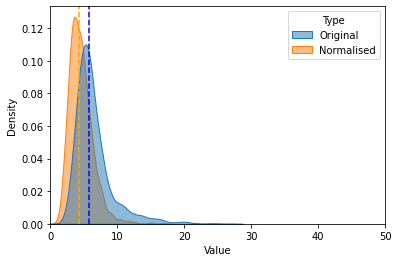

CV distribution for original and QC-RLSC normalised positive data:


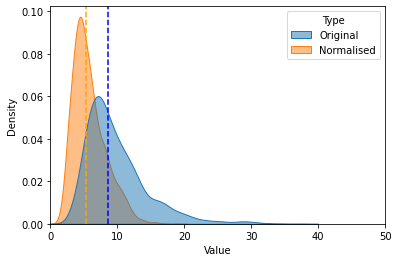

CV distribution for original and QC-RLSC normalised basic data:


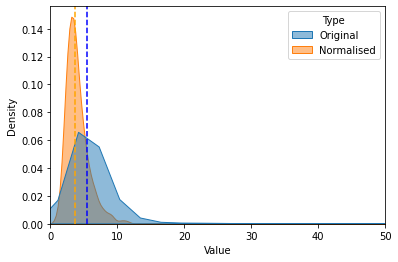

In [18]:
print('CV distribution for original and QC-RLSC normalised negative data:')
neg_dat_norm2, neg_dat_orig2 = remove_unwanted_features(neg_dat_norm,neg_dat,5,50)
print('CV distribution for original and QC-RLSC normalised positive data:')
pos_dat_norm2, pos_dat_orig2 = remove_unwanted_features(pos_dat_norm,pos_dat,5,50)
print('CV distribution for original and QC-RLSC normalised basic data:')
basic_dat_norm2, basic_dat_orig2 = remove_unwanted_features(basic_dat_norm,basic_dat,5,50)

## Check a specific variable to see how it is affected by the normalisation procedure:

In [ ]:
# Choose a random feature id:
var_of_interest = pos_dat_orig2.columns[120]

# Visualise the normalised values:
print('Current status after normalisation:')
sns.relplot(x="Run_order", y=var_of_interest, hue="QC", sizes = (100,30),size = 'QC',data=pos_dat_norm2)
plt.show()

print('Signal intensities before normalisation:')
# Visualise the original values:
sns.relplot(x="Run_order", y=var_of_interest, hue="QC", sizes = (100,30),size = 'QC',data=pos_dat_orig2)
plt.show()

## Remove outliers:

Outlier detection for negative data:


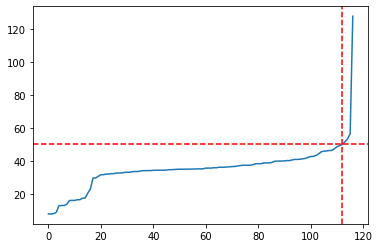

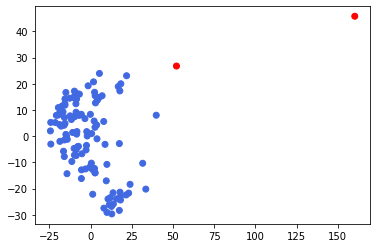

Outlier detection for positive data:


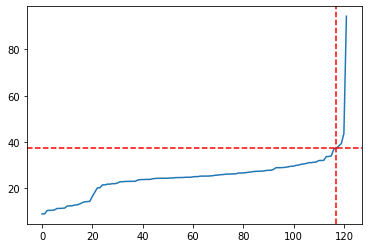

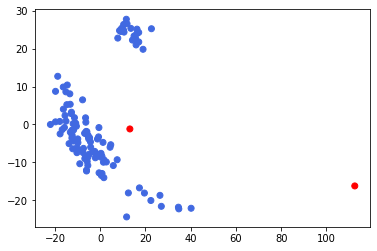

Outlier detection for basic data:


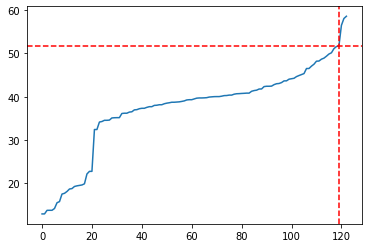

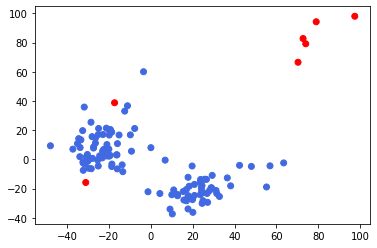

In [21]:
print('Outlier detection for negative data:')
neg_dat_norm2 = outlier_detection_and_removal(neg_dat_norm2, s = 0.2)
print('Outlier detection for positive data:')
pos_dat_norm2 = outlier_detection_and_removal(pos_dat_norm2, s = 0.2)
print('Outlier detection for basic data:')
basic_dat_norm2 = outlier_detection_and_removal(basic_dat_norm2, s = 0.1)

## Compare results before and after outlier removal:

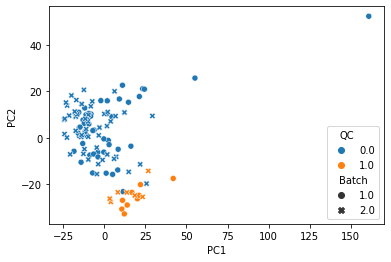

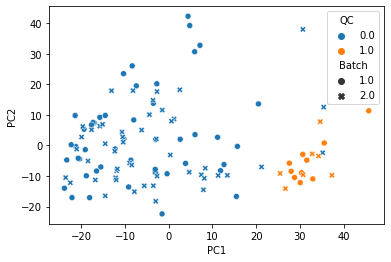

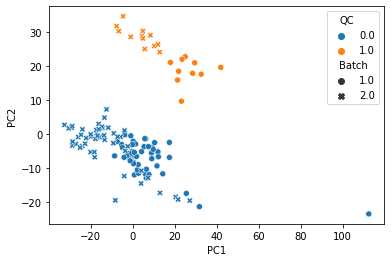

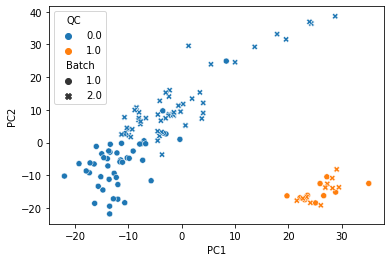

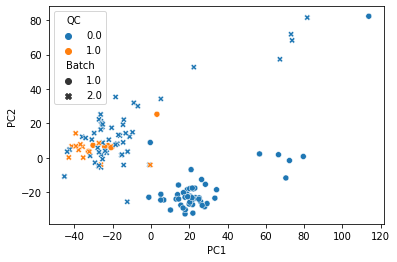

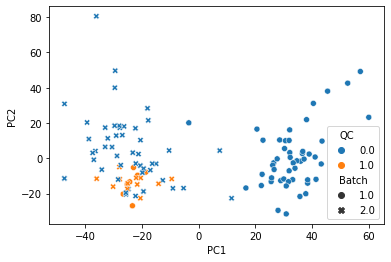

In [22]:
# Original:
print('Neg data before outlier removal:')
PCA_visualisation(neg_dat_orig2)
# Normalised:
print('Neg data after outlier removal:')
PCA_visualisation(neg_dat_norm2)

# Original:
print('Pos data before outlier removal:')
PCA_visualisation(pos_dat_orig2)
# Normalised:
print('Pos data after outlier removal:')
PCA_visualisation(pos_dat_norm2)

# Original:
print('Basic data before outlier removal:')
PCA_visualisation(basic_dat_orig2)
# Normalised:
print('Basic data after outlier removal:')
PCA_visualisation(basic_dat_norm2)

## Removal of residual batch effects:

In [24]:
# Remove QC samples from the data:
neg_dat = neg_dat_norm2[neg_dat_norm2['QC'] == 0]
pos_dat = pos_dat_norm2[pos_dat_norm2['QC'] == 0]
basic_dat = basic_dat_norm2[basic_dat_norm2['QC'] == 0]

# Remove batch effects:
neg_dat_corrected = pycombat(neg_dat.iloc[:,4:].T,neg_dat['Batch'].tolist())
pos_dat_corrected = pycombat(pos_dat.iloc[:,4:].T,pos_dat['Batch'].tolist())
basic_dat_corrected = pycombat(basic_dat.iloc[:,4:].T,basic_dat['Batch'].tolist())

# Prepare data:
neg_corrected = pd.concat([neg_dat.iloc[:,:4],neg_dat_corrected.T],axis = 1)
pos_corrected = pd.concat([pos_dat.iloc[:,:4],pos_dat_corrected.T],axis = 1)
basic_corrected = pd.concat([basic_dat.iloc[:,:4],basic_dat_corrected.T],axis = 1)

# Visualise the data after batch-correction:
print('Neg data after batch correction:')
PCA_visualisation(neg_corrected)

print('Pos data after batch correction:')
PCA_visualisation(pos_corrected)

print('Basic data after batch correction:')
PCA_visualisation(basic_corrected)

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\sigurdur.karvelsson\Anaconda3\envs\mynewenv\lib\site-packages\combat\pycombat.py:358: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batches = np.asarray(batches)
C:\Users\sigurdur.karvelsson\Anaconda3\envs\mynewenv\lib\site-packages\combat\pycombat.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adjust = np.asarray([g_new, d_new])


## Match processed metabolomic data to the metadata, and save to .csv file:

In [26]:
# Match metadata to process metabolomic data:
neg_dat = match_ms_samples_to_patients(neg_corrected,meta_dat_neg)
pos_dat = match_ms_samples_to_patients(pos_corrected,meta_dat_pos)
basic_dat = match_ms_samples_to_patients(basic_corrected,meta_dat_basic)

# Find all the common patients that are left in all datasets:
common_patients = list(set(neg_dat['patient_id'].tolist()).intersection(pos_dat['patient_id'].tolist(), basic_dat['patient_id'].tolist()))
id_neg = [neg_dat['patient_id'].tolist().index(x) for x in common_patients]
id_pos = [pos_dat['patient_id'].tolist().index(x) for x in common_patients]
id_basic = [basic_dat['patient_id'].tolist().index(x) for x in common_patients]

# Merge all datasets into a single dataset:
final_data = pd.concat([neg_dat.iloc[id_neg,4:].reset_index().iloc[:,1:],pos_dat.iloc[id_pos,4:].reset_index().iloc[:,1:],basic_dat.iloc[id_basic,4:].reset_index().iloc[:,1:]],axis = 1)
final_data.index = common_patients

# Merge extremely similar peaks with a pearson correlation of 0.8, and a ppm threshold of 3:
identical_pairs = identify_extremely_similar_peaks(final_data,0.8,3)
final_data2 = replace_identical_peaks_with_average(final_data,identical_pairs)

# Scale and write to csv:
final_scaler = StandardScaler()
scaled_dat = final_scaler.fit_transform(final_data2.values)
final_scaled_data = pd.DataFrame(scaled_dat,index = final_data2.index,columns = final_data2.columns)
print('Final dataset with ',final_scaled_data.shape[0],' samples and ',final_scaled_data.shape[1],'features')
final_scaled_data.to_csv('All_data_normalised_15SEP2022.csv')

Final dataset with  95  samples and  5412 features


C:\Users\sigurdur.karvelsson\AppData\Local\Temp\ipykernel_21864\1716645374.py:310: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
